In [149]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [150]:
data_location = 'Data\\train.csv'
train = pd.read_csv(data_location, index_col = 'Id')
test = pd.read_csv('Data\\test.csv', index_col = 'Id')
train

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500


In [151]:
train.shape

(1460, 80)

In [152]:
nan = train.isnull().sum()
missing_values = nan[nan > 0]
missing_values

to_remove = missing_values[missing_values > 600].index #any feature with more than 600 missing values is usless and imputation might throw off the model
train.drop(to_remove,axis = True,inplace = True)

Drop ``Alley``, ``PoolQC`` , ``Fence`` and ``MiscFeature`` and ``FireplaceQu`` as they have a heavy mjoriy of missing data and might throw off model

5 down, 65 to go

Next I will impute the rest of the missing data using the most frequent value from each column

In [161]:
from sklearn.impute import SimpleImputer

s = (train.dtypes == 'object')
object_cols = list(s[s].index)

train_imp = train.copy()

cat_imp = SimpleImputer(strategy='most_frequent')
train_imp[object_cols] = cat_imp.fit_transform(train[object_cols])

#train_imp.columns = train.columns
#train_imp.index.name = 'Id'

In [165]:
reg_imp = SimpleImputer()

reg_cols = train.drop(object_cols, axis=1).columns

train_imp[reg_cols] = reg_imp.fit_transform(train[reg_cols])

Next I will use Mutual information to try and detmin a smaller subset of features to use

In [169]:
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X,y):
    for colname in X.select_dtypes("object"):
        X[colname], _ = X[colname].factorize()
    discrete_features = X.dtypes == int
    
    mi_scores = mutual_info_regression(X,y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores



def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.axvline(scores.describe()['50%'], color = 'k') # tentative cutoff line of the lower 50%
    plt.title("Mutual Information Scores")


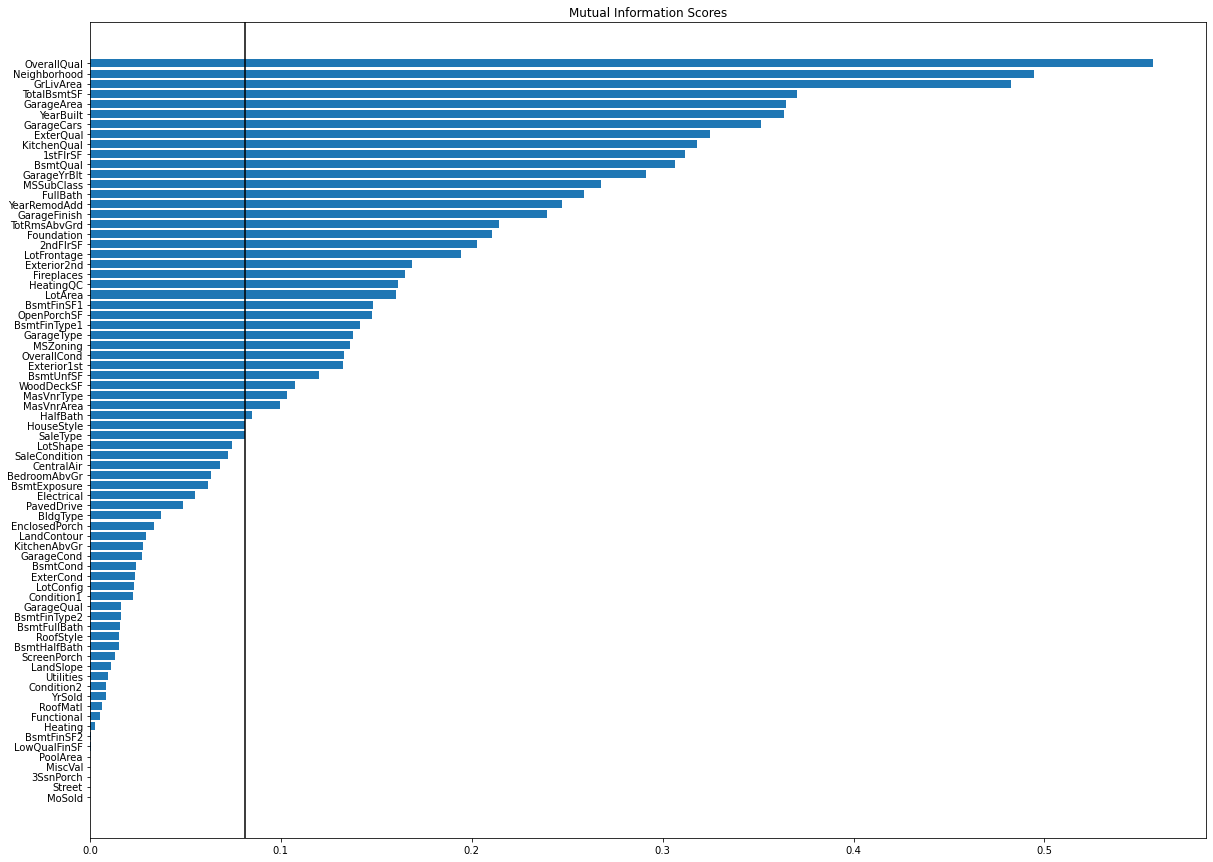

In [170]:
X = train_imp.drop('SalePrice',axis =1)
y = train_imp['SalePrice']
MI_score = make_mi_scores(X,y)
plt.figure(figsize=(20,15))
plot_mi_scores(MI_score)


With the exception of a few outliers near the bottom of the chart such as the ``2nd floor`` space this chart seems to represent the things that buyers typiclly look for most in a house, such as the top features being about the overall qualit of the property and the quality of the heating system. I will tentitivly determin that I will include any score

In [171]:
to_drop = MI_score[MI_score < MI_score.describe()['50%']].index
train_drop = train_imp.drop(to_drop, axis =1 )

In [174]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()

s = (train_drop.dtypes == 'object')
object_cols = list(s[s].index)

train_drop[object_cols] = encoder.fit_transform(train_drop[object_cols])

# train_encoded.index = train_drop.index
# train_encoded.index.name = 'Id'


In [180]:
train_drop['BsmtQual']

Id
1       2.0
2       2.0
3       2.0
4       3.0
5       2.0
       ... 
1456    2.0
1457    2.0
1458    3.0
1459    3.0
1460    3.0
Name: BsmtQual, Length: 1460, dtype: float64

<AxesSubplot:>

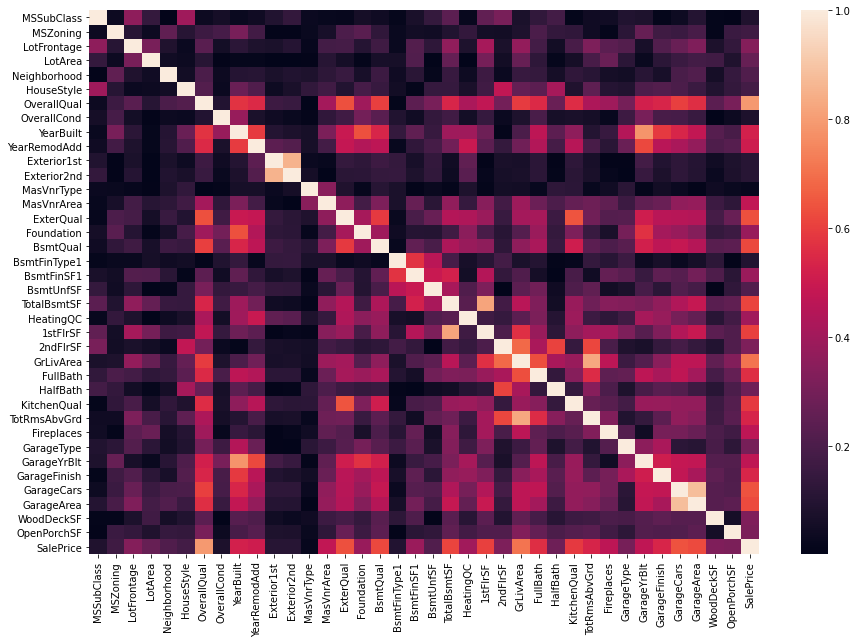

In [189]:
plt.figure(figsize = (15,10))
sns.heatmap(abs(train_drop.corr()))

<AxesSubplot:xlabel='GarageCars', ylabel='GarageArea'>

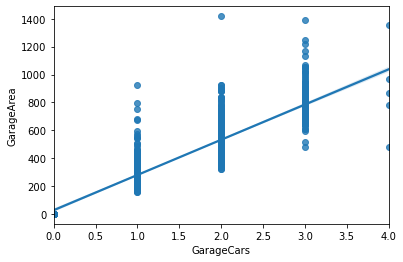

In [188]:
sns.regplot(x = train_drop['GarageCars'], y = train_drop['GarageArea'])

This relatoinship makes sense as to house more cars you will need more area in th garage, may combine these into a single variable

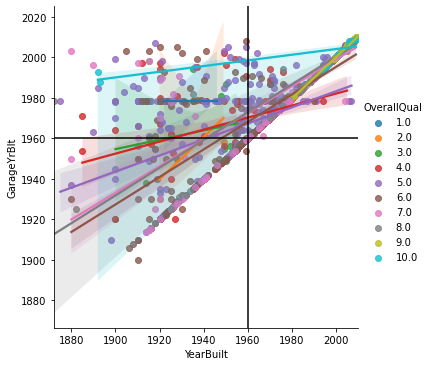

In [204]:
sns.lmplot(x = 'YearBuilt', y = 'GarageYrBlt', hue = 'OverallQual', data = train_drop)
plt.axvline(1960, color = 'k')
plt.axhline(1960, color = 'k')

In [199]:
train_drop['YearBuilt']

Id
1       2003.0
2       1976.0
3       2001.0
4       1915.0
5       2000.0
         ...  
1456    1999.0
1457    1978.0
1458    1941.0
1459    1950.0
1460    1965.0
Name: YearBuilt, Length: 1460, dtype: float64